In [1]:
# All necessary imports. Some may be redundant
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from PIL import Image
# Progress Bards
from tqdm.notebook import tqdm

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# If run locally, set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 - Below is a crucial shift in preprocessing technique for this particular notebook. To aid in the model predicting and characterizing each image to a particular disease, I shifted the diagnostic keywords to be associated not with right or left fundus but with the filename/ground truth relationship that will be established in our final df. This way, the model will work with:

    - A filename referencing a particular image
    - The ground truth label to that image
    - The patient age and gender
    - The diagnostic words associated with that image

 - As a result, when testing, the model can depend on the image, patient age, gender, and diagnostic words to determine disease.

In [3]:
# Fiel paths for saved data
drive_path = '/content/drive/MyDrive/Capstone_Final/Ocular_Disease_Folder'
csv_file = os.path.join(drive_path, 'full_df.csv')
img_dir = os.path.join(drive_path, 'preprocessed_images')

In [4]:
# Reading in full_df.csv data, still need to manage img data
df = pd.read_csv(csv_file)
print("Columns in CSV:", df.columns.tolist())

# Set the filename feature as our ImageFiler reference
# Also setting the labels feature as the predicted ground truth label
df["ImageFile"] = df["filename"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["PredictedLabel"] = df["labels"].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else None)

# Rename and setup the Right, Left eye images and diagnostic keywords
df["RightFundus"] = df["Right-Fundus"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["LeftFundus"] = df["Left-Fundus"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["RightDiagnostic"] = df["Right-Diagnostic Keywords"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["LeftDiagnostic"] = df["Left-Diagnostic Keywords"].apply(lambda x: x.strip() if isinstance(x, str) else None)

# Diagnostic Keywords assigned to our ImageFile feature based on previous Right/Left Fundus features.
# This will make the Right/Left Fundus features irrelevant
def assign_diagnostic(row):
    if row["ImageFile"] == row["RightFundus"]:
        return row["RightDiagnostic"]
    elif row["ImageFile"] == row["LeftFundus"]:
        return row["LeftDiagnostic"]
    else:
        return None

df["DiagnosticKeywords"] = df.apply(assign_diagnostic, axis=1)
df.drop(columns=["Right-Fundus", "Left-Fundus"], inplace=True)

# Setting up patient demographics
df["PatientAge"] = pd.to_numeric(df["Patient Age"], errors='coerce')
df["PatientSexNumeric"] = df["Patient Sex"].map({"Male": 0, "Female": 1})

Columns in CSV: ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename']


In [5]:
# We can now setup the final dataframe
final_df = df[[
    "ImageFile",
    "PredictedLabel",
    "PatientAge",
    "PatientSexNumeric",
    "RightDiagnostic",
    "LeftDiagnostic",
    "DiagnosticKeywords"
]].copy()

final_df.reset_index(drop=True, inplace=True)
print("Final DataFrame Sneak Peak")
print(final_df.head())

Final DataFrame Sneak Peak
     ImageFile PredictedLabel  PatientAge  PatientSexNumeric  \
0  0_right.jpg              N          69                  1   
1  1_right.jpg              N          57                  0   
2  2_right.jpg              D          42                  0   
3  4_right.jpg              D          53                  0   
4  5_right.jpg              D          50                  1   

                          RightDiagnostic  \
0                           normal fundus   
1                           normal fundus   
2  moderate non proliferative retinopathy   
3       mild nonproliferative retinopathy   
4  moderate non proliferative retinopathy   

                                      LeftDiagnostic  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferat

In [6]:
final_df.info()
final_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ImageFile           6392 non-null   object
 1   PredictedLabel      6392 non-null   object
 2   PatientAge          6392 non-null   int64 
 3   PatientSexNumeric   6392 non-null   int64 
 4   RightDiagnostic     6392 non-null   object
 5   LeftDiagnostic      6392 non-null   object
 6   DiagnosticKeywords  6392 non-null   object
dtypes: int64(2), object(5)
memory usage: 349.7+ KB


(6392, 7)

 - The dataframe above is perfect, including all necessary features without anything confusing or excessive.

 - Now we need to refine the final dataframe to be used in our multimodal neural network. We are working with a mix of image, text, and numerical data. From dataset exploration in previous iterations, the numerical and image data are already in a great space. Given the changes to the diagnostic keywords, need to refine them a bit.

In [7]:
final_df.isnull().sum()

,0
ImageFile,0
PredictedLabel,0
PatientAge,0
PatientSexNumeric,0
RightDiagnostic,0
LeftDiagnostic,0
DiagnosticKeywords,0


In [8]:
# Fill in any missing diagnostic keywords with empty string as to not effect model unnecessarily
diagnostic_text = final_df["DiagnosticKeywords"].fillna("")

# Vectorize textual data with TF–IDF and limit it to 20 features which is already excessive
vectorizer = TfidfVectorizer(max_features=20)
diagnostic_tfidf = vectorizer.fit_transform(diagnostic_text).toarray()  # shape: (n_samples, 20)

In [9]:
# Preprocess the demographic data
# For patient age, we set the missing values to the mean and reshape to (X, 1)
age_array = final_df["PatientAge"].fillna(final_df["PatientAge"].mean()).values.reshape(-1, 1)
# For patient sex, we fill in missing values with 0 and reshape to (X, 1)
sex_array = final_df["PatientSexNumeric"].fillna(0).values.reshape(-1, 1)

# Concatenate togehter age, sex, and diagnostic TF–IDF vectors (20 features + 1 age + 1 sex = 22)
metadata_array = np.concatenate([age_array, sex_array, diagnostic_tfidf], axis=1)
print("Metadata vector shape:", metadata_array.shape)

# Add a metadata vector as a new column in final_df so that each instance has a list fo concatenated info
final_df["Metadata"] = [metadata_array[i].tolist() for i in range(metadata_array.shape[0])]
print("Instance metadata vector: ", final_df["Metadata"].iloc[0])

Metadata vector shape: (6392, 22)
Instance metadata vector:  [69.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7069700856180804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7072434503345819, 0.0, 0.0, 0.0, 0.0]


 - Next is balancing the dataset. The data on hand is severely imbalanced, the largest difference being Normal (N) diagnosis and Hypertension (H) diagnosis. N is 22 times larger than H.

 - Previous attempts at balancing included adding weight penalties to respective classes to more severly punish the model for poor guesses on smaller sized labels or upsampling to total amount of "C" label while downsampling other excessive labels to that respective amount.

 - In the end, I decided that a deep neural network with a complex architecture and plenty training techniques designed to prevent overfitting (L2 regularization, batch training, dropout, etc.) would be better on a smaller sized yet equally balanced dataset than other approaches.

 - As such, we set the dataset equal to the smallest sum of instances present of any labels, that being "H" at 128 total instances.

Total Count of Images Per Label:
PredictedLabel
A     266
C     293
D    1608
G     284
H     128
M     232
N    2873
O     708


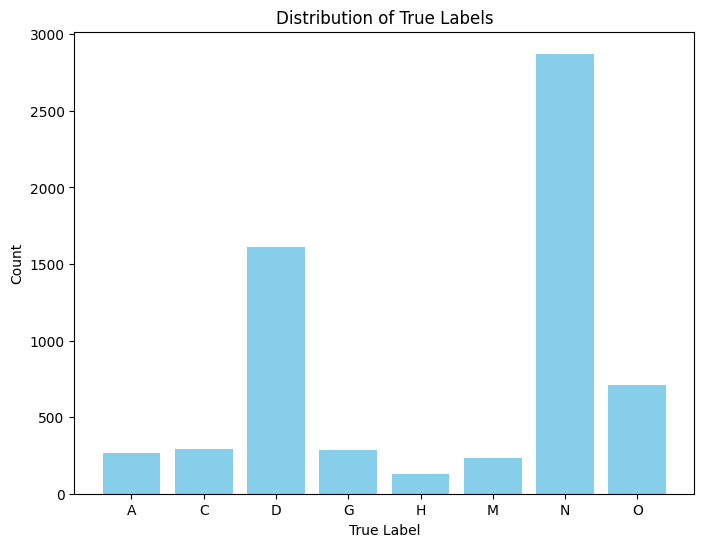

In [10]:
# First exploration of image class balance
label_counts = final_df['PredictedLabel'].value_counts().sort_index()
print("Total Count of Images Per Label:")
print(label_counts.to_string())

# Visualization of our class balance
plt.figure(figsize=(8,6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel("True Label")
plt.ylabel("Count")
plt.title("Distribution of True Labels")
plt.show()

 - Here we balance out the dataset

In [11]:
########### 293 yielded results, let's see
target_count = 128
print("Target count for each class:", target_count)

resampled_dfs = []
# Loop over each label in PredictedLabel feature
for label in final_df['PredictedLabel'].unique():
    # All instances of the label
    group = final_df[final_df['PredictedLabel'] == label]
    # If the group has fewer than our target count, sample with replacement. Otherwise, sample w/o replacement.
    resampled_group = group.sample(n=target_count, random_state=39, replace=(len(group) < target_count))
    resampled_dfs.append(resampled_group)

# Concatenate all resampled groups to a new dataframe
balanced_df = pd.concat(resampled_dfs).reset_index(drop=True)
print("Balanced dataframe shape:", balanced_df.shape)
print("Balanced label distribution:")
print(balanced_df['PredictedLabel'].value_counts())

# Reassign our dataframe to the balanced dataset
final_df = balanced_df.copy()

Target count for each class: 128
Balanced dataframe shape: (1024, 8)
Balanced label distribution:
PredictedLabel
N    128
D    128
O    128
M    128
H    128
C    128
A    128
G    128
Name: count, dtype: int64


 - Now, we can map out the string labels to a numerical figure and set the final iteration of our data to return an image, label, and our metadata tensor per instance

In [12]:
# Create label mapping from unique labels and convert to a numerical value
unique_labels = sorted(final_df["PredictedLabel"].dropna().unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print("Label mapping:", label_mapping)

# Utilized classes for modularity to change adn experiment
# Setup for multimodal input
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, label_mapping=None):
        # DataFrame
        self.data = dataframe.reset_index(drop=True)
        # Pathway to preprocessed images in Google Drive
        self.img_dir = img_dir
        # Preprocessing transformations of images
        self.transform = transform
        # Dictionary mapping label strings to number values
        self.label_mapping = label_mapping

    def __len__(self):
        # Returns number of total samples in dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Loads in the row corresponding to our index
        row = self.data.iloc[idx]
        # Loads in the image file from path
        img_path = os.path.join(self.img_dir, row["ImageFile"])
        # Opens image and converts to RGB color grade
        img = Image.open(img_path).convert("RGB")
        # Experimented with transformations, this applies transformations should we use them
        if self.transform:
            img = self.transform(img)
        # Converts label to number
        label = row["PredictedLabel"]
        numeric_label = self.label_mapping.get(label, -1)
        # Converts our metadata vector (list type) to a float type tensor
        metadata = torch.tensor(row["Metadata"], dtype=torch.float)
        return img, numeric_label, metadata


Label mapping: {'A': 0, 'C': 1, 'D': 2, 'G': 3, 'H': 4, 'M': 5, 'N': 6, 'O': 7}


 - Given the visual similarity of images and incredibly small dataset, we will transform the image data to introduce some variability via data augmentation for better generalization down the line in testing and real world deployment. Note that the figures provided in the transform.Normalize function were previously derived from calculated normalization statistics, but hard coded here for sake of convenience/time given to recalculating. Added back in code.

# Try with calculated normalization stats

In [13]:
# Simple dataset with express purpose of loading images to convert to tensors
# Converts images to tensors with pixel values in [0, 1] range
simple_transform = transforms.ToTensor()

class SimpleImageDataset(Dataset):
    def __init__(self, df, image_directory, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_directory = image_directory
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_directory, row["ImageFile"])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
# **NOTE: CHATGPT USED HERE FOR FUNCTIONS, did NOT find sufficient resources to calculate out
# Personal calculations were tremendously off**
norm_dataset = SimpleImageDataset(final_df, img_dir, transform=simple_transform)
norm_loader = DataLoader(norm_dataset, batch_size=16, shuffle=False, num_workers=4)

# Initializes accumulators for both sum, squared sum per channel
# Creates a counter for total images
channel_sum = torch.zeros(3)
channel_sq_sum = torch.zeros(3)
num_images = 0

# Iterates through the dataset and calculates statistics
for images in norm_loader:
    batch_size, channels, height, width = images.size()
    num_images += batch_size
    # Reshape images to (batch, channels, height*width)
    images = images.view(batch_size, channels, -1)
    # Sum the mean of each channel per image
    channel_sum += images.mean(dim=2).sum(dim=0)
    # Sum the standard deviation of each channel per image
    channel_sq_sum += images.std(dim=2).sum(dim=0)

# Compute the overall mean and standard deviation per channel
mean = channel_sum / num_images
std = channel_sq_sum / num_images

print("Calculated normalization mean:", mean)
print("Calculated normalization std:", std)
# CHATGPT CODE ENDS HERE

Calculated normalization mean: tensor([0.4468, 0.2905, 0.1625])
Calculated normalization std: tensor([0.2617, 0.1815, 0.1095])


In [14]:
train_transform = transforms.Compose([
    # Randomly flip an image
    transforms.RandomHorizontalFlip(),
    # Randomly rotate it 55 degs
    transforms.RandomRotation(55),
    # Randomly change color properties
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    # Convert from PIL to PyTorch tensor
    transforms.ToTensor(),
    # Normalize tensor figures
    transforms.Normalize(mean=[0.4468, 0.2905, 0.1625], std=[0.2617, 0.1815, 0.1095])
])

val_transform = transforms.Compose([
    # Convert img to Pytorch Tensor
    transforms.ToTensor(),
    # Normalize tensor figures
    transforms.Normalize(mean=[0.4468, 0.2905, 0.1625], std=[0.2617, 0.1815, 0.1095])
])


 - Initial attempts were used for a CNN model of increasing depth and width, hyperparameter tuning, etc. but accuracy never increased beyond 55%, precision beyond 39% and F1 Score beyond 36%. Consideirng many approaches utilize a pretrained ResNet model or VGG36 model, I decided to emulate a ResNet structure in our project.

In [15]:
# NN is based on a residual block with convolutional block attention module mechanisms
# In general, heightens feature representation and abstraction for model to better grasp underlying patterns
# Between features present in images and their respective labels
class BasicBlock_CBAM(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.1):
        super(BasicBlock_CBAM, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # Attention mechanism is here
        self.cbam = CBAM(planes, reduction=16, kernel_size=7)
        self.dropout = nn.Dropout(dropout_rate)
        # A shortcut connection for residual learning
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        # Attention mechanism is applied to blocks output
        out = self.cbam(out)
        # Residual connection here
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CBAM (Convolutional Block Attention Module) for spatial and channel attention refining feature maps
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Avg and max pooling w/ MLP
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()
        # Aptial attention
        # Convolution layer over concatenated avg with max pooled features
        self.conv_after_concat = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        # Channel attention
        avg_out = self.mlp(self.avg_pool(x).view(b, c))
        max_out = self.mlp(self.max_pool(x).view(b, c))
        channel_att = self.sigmoid_channel(avg_out + max_out).view(b, c, 1, 1)
        x = x * channel_att
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.conv_after_concat(torch.cat([avg_out, max_out], dim=1))
        spatial_att = self.sigmoid_spatial(spatial_att)
        x = x * spatial_att
        return x

# ASPP (Atrous Spatial Pyramid Pooling) for multi-scale feature extraction
# Extracts features at multiple different scales using dilated convolutions
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6, bias=False)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12, bias=False)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18, bias=False)
        self.conv_1x1_output = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        # Concatenate all features from all parallel convolutions
        x = torch.cat([x1, x2, x3, x4], dim=1)
        # Now reduce concatenated features using 1x1 convolution
        x = self.conv_1x1_output(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Resnet Model with CBAM and ASPP incorporated in it
# Given limited dataset and img complexity, this should be sufficient to extract image features
class ResNetModel(nn.Module):
    def __init__(self, block, num_blocks, num_classes=8, dropout_rate=0.1, width_factor=2):
        super(ResNetModel, self).__init__()
        self.width_factor = width_factor
        # After our first convolutional layer iteration, this should be the calculation for number of channels
        self.in_planes = 64 * width_factor
        # Setup and initialize first convolutional layer
        self.conv1 = nn.Conv2d(3, 64 * width_factor, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * width_factor)
        self.relu = nn.ReLU(inplace=True)
        # Max pooling for spatial dimension reduction
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Using [4, 6, 8, 6] blocks per layer, with increasing depth
        # Dropout every layer to prevent overfitting, extensive overfitting reduction techniques used throughout
        self.layer1 = self._make_layer(block, 64 * width_factor, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128 * width_factor, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256 * width_factor, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512 * width_factor, num_blocks[3], stride=2, dropout_rate=dropout_rate)

        # ASPP portion for multi scale feature extraction
        self.aspp = ASPP(512 * width_factor * block.expansion, 256 * width_factor)
        # Prefer global average pooling for fixed-size feature vector, was troublesome previously
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Heavy dropout before fully connected layer
        self.dropout_fc1 = nn.Dropout(0.5)
        # Fully connected layer
        # Creates image features which are 128 dimensional
        self.fc1 = nn.Linear(256 * width_factor, 128)
        self.dropout_fc2 = nn.Dropout(0.5)
        # Classification layer
        self.fc2 = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
        # Creates a sequential layer made up of several blocks
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s, dropout_rate=dropout_rate))
            # Gotta update channel size after every block
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Standard forward pass for classification BUT not used directly in multi modal resnet
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.aspp(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_fc1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc2(x)
        x = self.fc2(x)
        return x

 - To get a feel of the full architecture, will instantiate a false model to inspect

In [16]:
false_model = ResNetModel(BasicBlock_CBAM, [4, 6, 8, 6], num_classes=len(unique_labels), dropout_rate=0.3, width_factor=2)
total_params = 0
print("\nTrainable parameters:")
for name, param in false_model.named_parameters():
    if param.requires_grad:
        param_count = param.numel()
        total_params += param_count
        print(f"{name:40s} | shape: {str(list(param.shape)):20s} | count: {param_count}")
print(f"\nTotal trainable parameters: {total_params}")



Trainable parameters:
conv1.weight                             | shape: [128, 3, 7, 7]       | count: 18816
bn1.weight                               | shape: [128]                | count: 128
bn1.bias                                 | shape: [128]                | count: 128
layer1.0.conv1.weight                    | shape: [128, 128, 3, 3]     | count: 147456
layer1.0.bn1.weight                      | shape: [128]                | count: 128
layer1.0.bn1.bias                        | shape: [128]                | count: 128
layer1.0.conv2.weight                    | shape: [128, 128, 3, 3]     | count: 147456
layer1.0.bn2.weight                      | shape: [128]                | count: 128
layer1.0.bn2.bias                        | shape: [128]                | count: 128
layer1.0.cbam.mlp.0.weight               | shape: [8, 128]             | count: 1024
layer1.0.cbam.mlp.2.weight               | shape: [128, 8]             | count: 1024
layer1.0.cbam.conv_after_concat.weight   | 

 - 170,723,896 total trainable parameters. Previous attempts overloaded A100 Runtime instance (40GB GPU) on 10,000,000 parameters with large batch sizing. To run such a large model, we need Mixed Precision Training and smaller batch sizing. Later I wrapped it with torch for gradient scaling and updating the optimizer, so memory/computational use is reduced and training speed is increased. IIRC only possible in A100 environments.

In [17]:
class MultiModalFull(nn.Module):
    def __init__(self, num_classes, width_factor=2, dropout_rate=0.3, metadata_dim=22):
        # For above arguments, num_classes is number of output classes (8 labels)
        # width_factor is scaling factor for CNN branch
        # Dropout_rate is slef explanatory
        # metadatadim is metadata vector dimensionality
        super(MultiModalFull, self).__init__()
        # Image branch using the ResNet, CBAM, ASPP
        self.image_extractor = ResNetModel(
            BasicBlock_CBAM, [4, 6, 8, 6], num_classes=num_classes,
            dropout_rate=dropout_rate, width_factor=width_factor
        )
        # small MLP to process metadata vector and output 128-dimensional feature vector.
        self.metadata_branch = nn.Sequential(
            # Maps input medata data dimensions to 64 features
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            # Reduces to 32 features
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Final classifier concatenates image features and metadata features
        # Image features is 128, metadata features is 32
        self.classifier = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, image, metadata):
        # Extract image features
        # Expected shape is (batch, 128)
        image_features = self.get_image_features(image)
        # Process metadata through MLP, expected shape is (batch, 32)
        metadata_features = self.metadata_branch(metadata)
        # Concatenate image and metadata features along feature dimension
        combined_features = torch.cat([image_features, metadata_features], dim=1)
        # Pass concatenated features through final classifier
        output = self.classifier(combined_features)
        return output

    def get_image_features(self, image):
        # Extract image features up to fc1 which *should* be 128
        x = self.image_extractor.relu(self.image_extractor.bn1(self.image_extractor.conv1(image)))
        x = self.image_extractor.maxpool(x)
        x = self.image_extractor.layer1(x)
        x = self.image_extractor.layer2(x)
        x = self.image_extractor.layer3(x)
        x = self.image_extractor.layer4(x)
        x = self.image_extractor.aspp(x)
        x = self.image_extractor.avgpool(x)
        # Flatten tensor
        x = x.view(x.size(0), -1)
        x = self.image_extractor.dropout_fc1(x)
        # Grab features from fc1 (fully connected layer 1) with ReLU activation
        image_features = F.relu(self.image_extractor.fc1(x))
        return image_features

# Test the multi-modal model with fake inputs to see if it works
# Batch size 2
fake_image = torch.randn(2, 3, 512, 512).to(device)
fake_metadata = torch.randn(2, 22).to(device)
multimodal_model = MultiModalFull(num_classes=len(unique_labels), width_factor=2, dropout_rate=0.3, metadata_dim=22).to(device)
fake_output = multimodal_model(fake_image, fake_metadata)
print("Testing output shape of MultiModalFull: ", fake_output.shape)


Testing output shape of MultiModalFull:  torch.Size([2, 8])


In [18]:
# Split the balanced final_df into training and validation sets stratified by our prediction label
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=39, stratify=final_df["PredictedLabel"])
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Create dataset instances with MultiModal dataset class
train_dataset = MultiModalDataset(train_df, img_dir, transform=train_transform, label_mapping=label_mapping)
val_dataset = MultiModalDataset(val_df, img_dir, transform=val_transform, label_mapping=label_mapping)

# Create DataLoaders to iterate over the datasets, imperative to lower batch size and shuffle training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

Training samples: 819, Validation samples: 205


In [19]:
# Was initially 150, now 10-20 with optimizer change
num_epochs = 20
learning_rate = 1e-3

# Trial tracking to see improvements
writer = SummaryWriter(log_dir="runs/trials")

# Model, optimizer, scheduler, loss function initializer
model = MultiModalFull(num_classes=len(unique_labels), width_factor=2, dropout_rate=0.3, metadata_dim=22).to(device)
# Initially with Stochastic Gradient Descent as management of exploding gradients in previous models
# Now, with other techniques managing the issue, AdamW is best
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=3e-3, steps_per_epoch=len(train_loader), epochs=num_epochs, anneal_strategy='cos', pct_start=0.1)
# Previously used focal loss, avoid
criterion = nn.CrossEntropyLoss()

# IMPORTANT: Set up mixed precision training scaler to have sufficient computational resources to run model
scaler = torch.amp.GradScaler(device='cuda')

best_val_loss = float("inf")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Iterates over training data
    for imgs, labels, metadata in  tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
        # Moves data to specified device if running locally
        imgs = imgs.to(device)
        labels = labels.to(device)
        metadata = metadata.to(device)
        # Reset gradients for optimizer
        optimizer.zero_grad()
        # Forward pass w/ mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(imgs, metadata)
            loss = criterion(outputs, labels)
        # Backwards pass w/ gradient scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        # Clipping gradients to prevent exploding gradients problem mentioned above
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        # Updated lr scheduler
        scheduler.step()
        # Cumulative training loss
        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels, metadata in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            metadata = metadata.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs, metadata)
                loss = criterion(outputs, labels)
            running_val_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss = running_val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    writer.add_scalar("Train_Loss", train_loss, epoch)
    writer.add_scalar("Val_Loss", val_loss, epoch)

    # Save best model if and only if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_multimodal_model.pt")
        print("Best model saved!")

writer.close()

Epoch 1/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

<ipython-input-19-564c636891f1>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-19-564c636891f1>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20] - Train Loss: 2.1130, Val Loss: 2.1016
Best model saved!


Epoch 2/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/20] - Train Loss: 2.1010, Val Loss: 2.5609


Epoch 3/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/20] - Train Loss: 2.0730, Val Loss: 2.1617


Epoch 4/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/20] - Train Loss: 2.0137, Val Loss: 1.9129
Best model saved!


Epoch 5/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/20] - Train Loss: 1.8970, Val Loss: 1.7252
Best model saved!


Epoch 6/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/20] - Train Loss: 1.6966, Val Loss: 1.4328
Best model saved!


Epoch 7/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/20] - Train Loss: 1.4160, Val Loss: 1.0780
Best model saved!


Epoch 8/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/20] - Train Loss: 1.2097, Val Loss: 0.9761
Best model saved!


Epoch 9/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/20] - Train Loss: 1.0529, Val Loss: 0.7436
Best model saved!


Epoch 10/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/20] - Train Loss: 0.8074, Val Loss: 0.5621
Best model saved!


Epoch 11/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/20] - Train Loss: 0.7062, Val Loss: 0.3938
Best model saved!


Epoch 12/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/20] - Train Loss: 0.6339, Val Loss: 0.3826
Best model saved!


Epoch 13/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/20] - Train Loss: 0.5537, Val Loss: 0.2776
Best model saved!


Epoch 14/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/20] - Train Loss: 0.4569, Val Loss: 0.2490
Best model saved!


Epoch 15/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/20] - Train Loss: 0.4417, Val Loss: 0.2229
Best model saved!


Epoch 16/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/20] - Train Loss: 0.4474, Val Loss: 0.1958
Best model saved!


Epoch 17/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/20] - Train Loss: 0.4059, Val Loss: 0.1816
Best model saved!


Epoch 18/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/20] - Train Loss: 0.3526, Val Loss: 0.1717
Best model saved!


Epoch 19/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/20] - Train Loss: 0.3861, Val Loss: 0.1721


Epoch 20/20 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/20] - Train Loss: 0.3534, Val Loss: 0.1701
Best model saved!


In [20]:
# Load the best model for evaluation on the validation set
model.load_state_dict(torch.load("best_multimodal_model.pt"))
model.eval()

# Initialize lists for storing preds and ground truth labels
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels, metadata in tqdm(val_loader, desc="Testing", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)
        metadata = metadata.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(imgs, metadata)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=list(label_mapping.keys()))
print("Classification Report:")
print(report)

Testing:   0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-20-6c2f48d078fd>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Classification Report:
              precision    recall  f1-score   support

           A       0.96      1.00      0.98        26
           C       0.96      0.92      0.94        26
           D       0.89      1.00      0.94        25
           G       1.00      0.96      0.98        25
           H       1.00      0.92      0.96        26
           M       1.00      1.00      1.00        25
           N       1.00      1.00      1.00        26
           O       0.96      0.96      0.96        26

    accuracy                           0.97       205
   macro avg       0.97      0.97      0.97       205
weighted avg       0.97      0.97      0.97       205



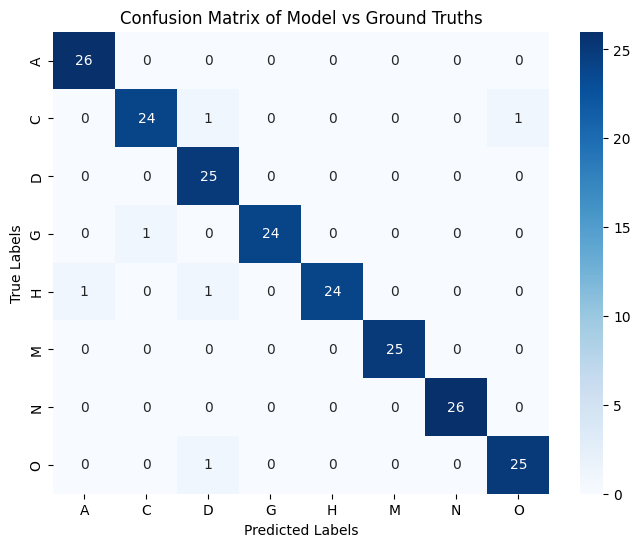

In [21]:
# Additional confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_mapping.keys()),
            yticklabels=list(label_mapping.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Model vs Ground Truths")
plt.show()

In [22]:
# Almost forgot, save the model!
torch.save(model.state_dict(), "best_model.pt")